# Face Recognition - Data Preparation and PCA
This notebook covers loading the ORL face dataset, preparing the data matrix and label vector, and performing PCA using scikit-learn.

In [1]:
import os
import numpy as np
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Constants
IMAGE_WIDTH = 92
IMAGE_HEIGHT = 112
DATASET_PATH = './data/'  # Change this to your actual dataset path

def load_images_and_labels(dataset_path):
    data = []
    labels = []
    for subject_id in range(1, 41):
        subject_path = os.path.join(dataset_path, f's{subject_id}')
        for img_name in os.listdir(subject_path):
            img_path = os.path.join(subject_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_flat = img.flatten()
            data.append(img_flat)
            labels.append(subject_id)
    return np.array(data), np.array(labels)

# Load images and labels
X, y = load_images_and_labels(DATASET_PATH)
print(f'Data shape: {X.shape}, Labels shape: {y.shape}')

Data shape: (400, 10304), Labels shape: (400,)


In [2]:
# Split into training and testing
X_train = X[::2]
y_train = y[::2]
X_test = X[1::2]
y_test = y[1::2]

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (200, 10304), Test shape: (200, 10304)


## PCA

Steps in PCA 
- Center the data: X = X - μ 
- Compute covariance matrix 
- Extract eigenvectors and eigenvalues 
- Project to new basis: Z = XW
- Reconstruct data: X = ZW^T + μ

In [3]:
from pca import PCA_GHALBAN
# from sklearn.metrics import pairwise_distances

pca = PCA_GHALBAN(alpha=0.95)
pca.fit(X_train)
X_train_pca = pca.transform(X_train) 

# print(f'PCA with GHALBAN, Components retained: {pca.components}')

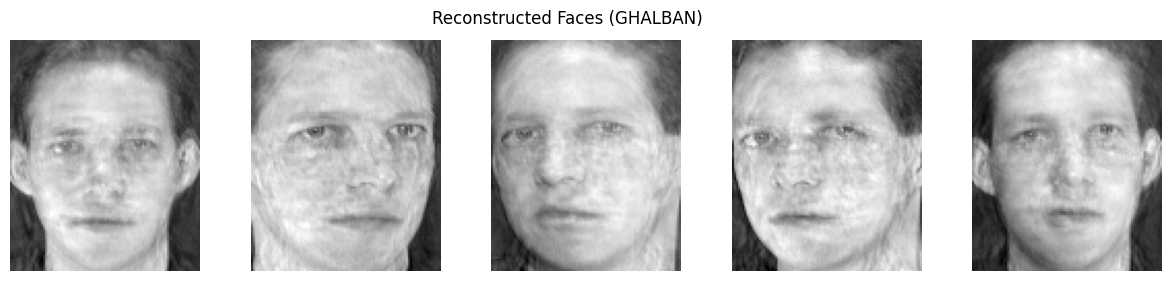

In [4]:
# Visualize a few reconstructed faces
reconstructed = pca.inverse_transform(X_train_pca[:5])

# Visualize a few reconstructed faces
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(reconstructed[i].reshape((112, 92)), cmap='gray')
    axs[i].axis('off')
plt.suptitle('Reconstructed Faces (GHALBAN)')
plt.show()

Reconstructed shape: (5, 10304)


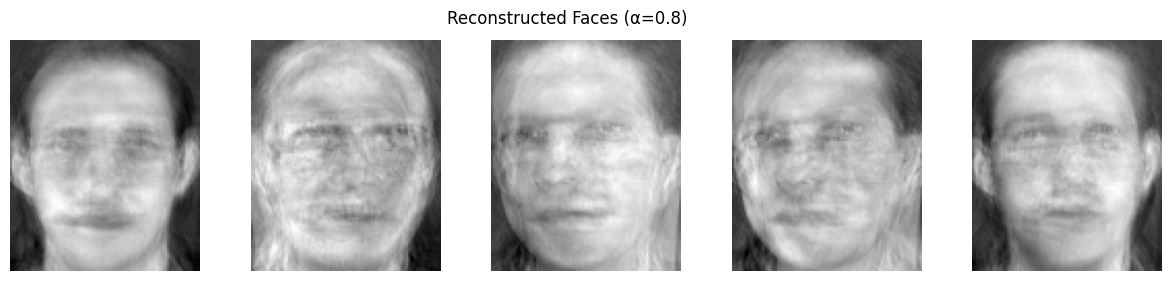

Reconstructed shape: (5, 10304)


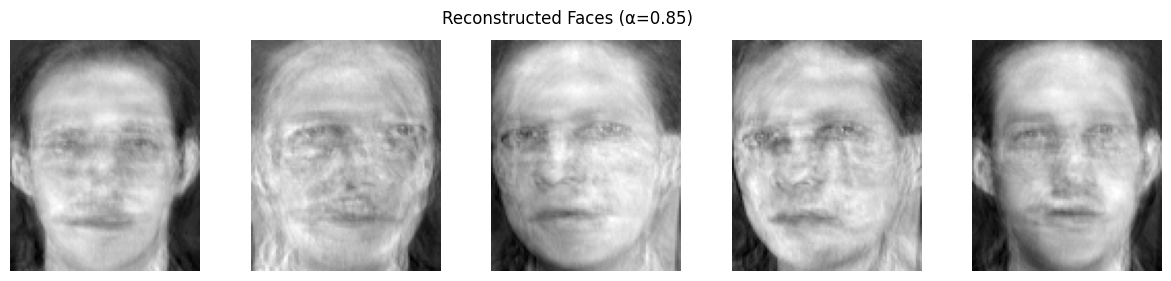

Reconstructed shape: (5, 10304)


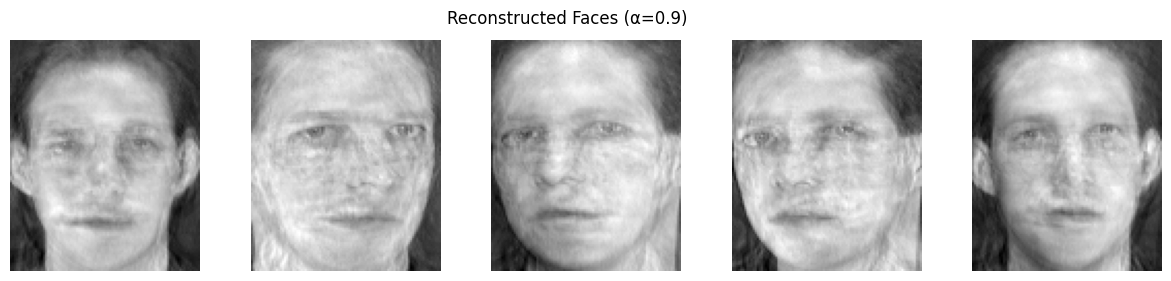

Reconstructed shape: (5, 10304)


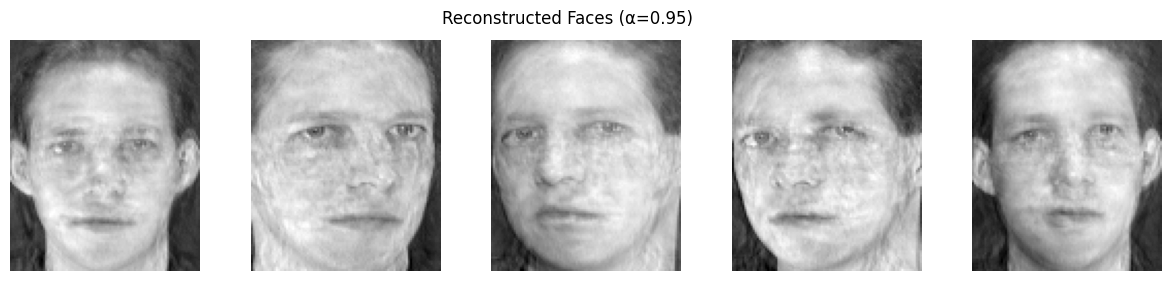

In [5]:
# PCA with variance retention
alphas = [0.8, 0.85, 0.9, 0.95]
pca_results = {}
X_train_pca = {}
X_test_pca = {}

for alpha in alphas:
    pca = PCA_GHALBAN(alpha=alpha)
    # we fit first using the training set
    pca.fit(X_train)

    # then we transform the training and test sets
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    # print(f'Alpha: {alpha}, Components retained: {pca.components}')
    pca_results[alpha] = {
        'pca': pca,
        'X_train_pca': X_train_pca,
        'X_test_pca': X_test_pca,
    }

    # Visualize a few reconstructed faces
    reconstructed = pca.inverse_transform(X_train_pca[:5])
    print(f'Reconstructed shape: {reconstructed.shape}')
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(reconstructed[i].reshape((112, 92)), cmap='gray')
        axs[i].axis('off')
    plt.suptitle(f'Reconstructed Faces (α={alpha})')
    plt.show()

In [6]:
# Save arrays for reuse in clustering step
np.save('./npy/X_train.npy', X_train)
np.save('./npy/X_test.npy', X_test)
np.save('./npy/y_train.npy', y_train)
np.save('./npy/y_test.npy', y_test)
for alpha in alphas:
    np.save(f'./npy/pca_alpha_{alpha}_train.npy', pca_results[alpha]['X_train_pca'])
    np.save(f'./npy/pca_alpha_{alpha}_test.npy', pca_results[alpha]['X_test_pca'])  

## KMeans Algorithm

In [7]:
import importlib
import kmeans as Models
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score

importlib.reload(Models)

<module 'kmeans' from 'm:\\FOE AU\\CSE 3\\second-term\\Pattern Recognition\\assignments\\Face_Recognition_Problem\\kmeans.py'>

In [8]:
def mapping_clusters_to_labels(cluster_indices, true_labels):
    cluster_label_map = {}
    
    for cluster in np.unique(cluster_indices):
        labels = true_labels[cluster_indices == cluster]

        if len(labels) > 0:
            majority_label = Counter(labels).most_common(1)[0][0]
            cluster_label_map[cluster] = majority_label
        else:
            cluster_label_map[cluster] = -1  # fallback
    return cluster_label_map

In [9]:
k_values = [20, 40, 60]
results = {}  # To store accuracy for each (alpha, K)

best_acc = 0
best_model = None
best_alpha = 0.8
cluster_label_mapping = []
for alpha in alphas:
    results[alpha] = {}
    for k in k_values:
        kmeans_model = Models.KMeans(n_clusters = k, random_state = 42)
        pca = pca_results[alpha]['pca']
        X_train_pca = pca_results[alpha]['X_train_pca']
        X_test_pca = pca_results[alpha]['X_test_pca']

        # Fit KMeans
        kmeans_model.fit(X_train_pca)

        # Predict clusters
        cluster_indices = kmeans_model.predict(X_train_pca)
        cluster_label_map = mapping_clusters_to_labels(cluster_indices, y_train)
        
        y_pred_train = np.array([cluster_label_map[c] for c in cluster_indices])
        
        y_pred_test_cluster_indices = kmeans_model.predict(X_test_pca)
        
        training_acc = accuracy_score(y_pred_train, y_train)
    
        test_cluster_indices = kmeans_model.predict(X_test_pca)
        
        y_pred_test = np.array([cluster_label_map[c] for c in test_cluster_indices])
        
        training_acc = accuracy_score(y_pred_train, y_train)
        testing_acc = accuracy_score(y_pred_test, y_test)
        
        if training_acc > best_acc:
            best_acc = training_acc
            best_model = kmeans_model
            best_alpha = alpha
            cluster_label_mapping = cluster_label_map

        results[alpha][k] = {
            "training_acc": training_acc,
            "testing_acc": testing_acc
        }
        print(f'Alpha: {alpha}, K: {k}, Training Accuracy: {training_acc:.4f}, Testing Accuracy: {testing_acc}')

Alpha: 0.8, K: 20, Training Accuracy: 0.4350, Testing Accuracy: 0.41
Alpha: 0.8, K: 40, Training Accuracy: 0.6600, Testing Accuracy: 0.61
Alpha: 0.8, K: 60, Training Accuracy: 0.7950, Testing Accuracy: 0.73
Alpha: 0.85, K: 20, Training Accuracy: 0.4250, Testing Accuracy: 0.4
Alpha: 0.85, K: 40, Training Accuracy: 0.6300, Testing Accuracy: 0.55
Alpha: 0.85, K: 60, Training Accuracy: 0.7850, Testing Accuracy: 0.705
Alpha: 0.9, K: 20, Training Accuracy: 0.4250, Testing Accuracy: 0.395
Alpha: 0.9, K: 40, Training Accuracy: 0.6200, Testing Accuracy: 0.555
Alpha: 0.9, K: 60, Training Accuracy: 0.7850, Testing Accuracy: 0.705
Alpha: 0.95, K: 20, Training Accuracy: 0.4150, Testing Accuracy: 0.375
Alpha: 0.95, K: 40, Training Accuracy: 0.6300, Testing Accuracy: 0.57
Alpha: 0.95, K: 60, Training Accuracy: 0.7950, Testing Accuracy: 0.685


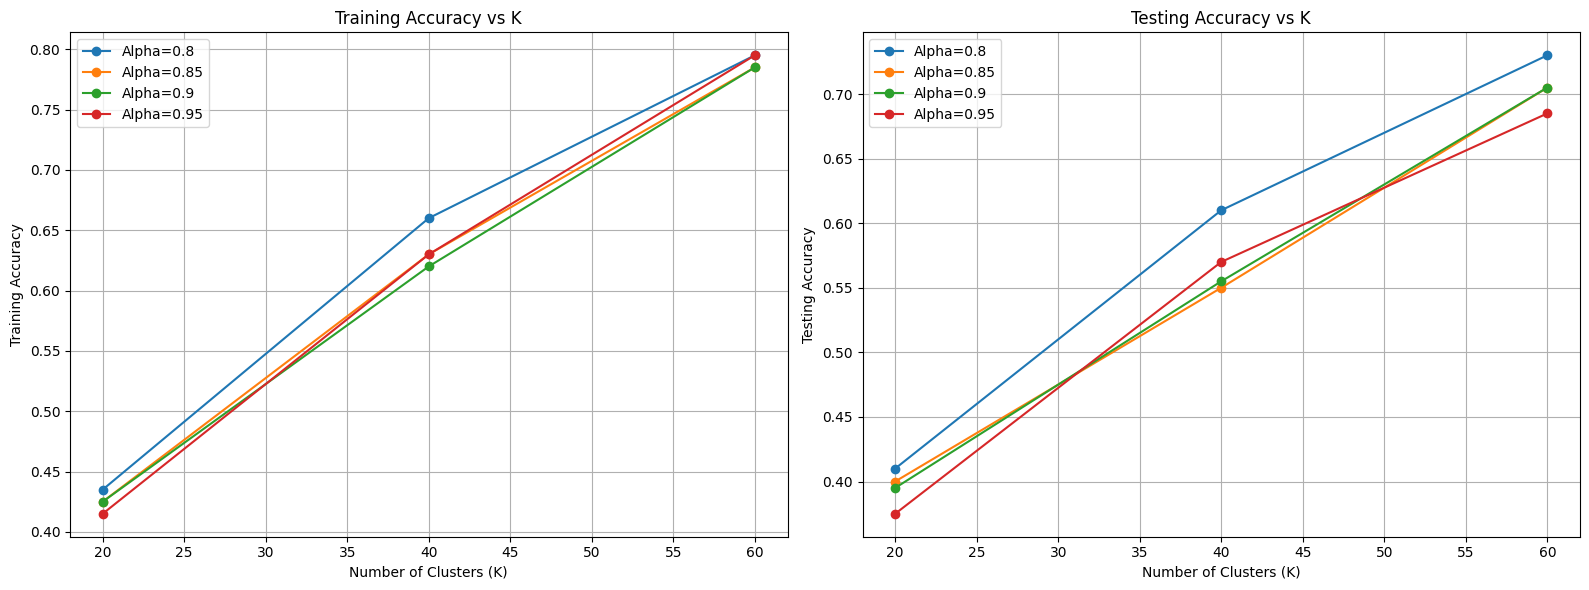

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot Training Accuracy
for alpha in results:
    training_accuracies = [results[alpha][k]['training_acc'] for k in k_values]
    axes[0].plot(k_values, training_accuracies, marker='o', label=f'Alpha={alpha}')

axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Training Accuracy')
axes[0].set_title('Training Accuracy vs K')
axes[0].legend()
axes[0].grid(True)

# Plot Testing Accuracy
for alpha in results:
    testing_accuracies = [results[alpha][k]['testing_acc'] for k in k_values]
    axes[1].plot(k_values, testing_accuracies, marker='o', label=f'Alpha={alpha}')

axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Testing Accuracy')
axes[1].set_title('Testing Accuracy vs K')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

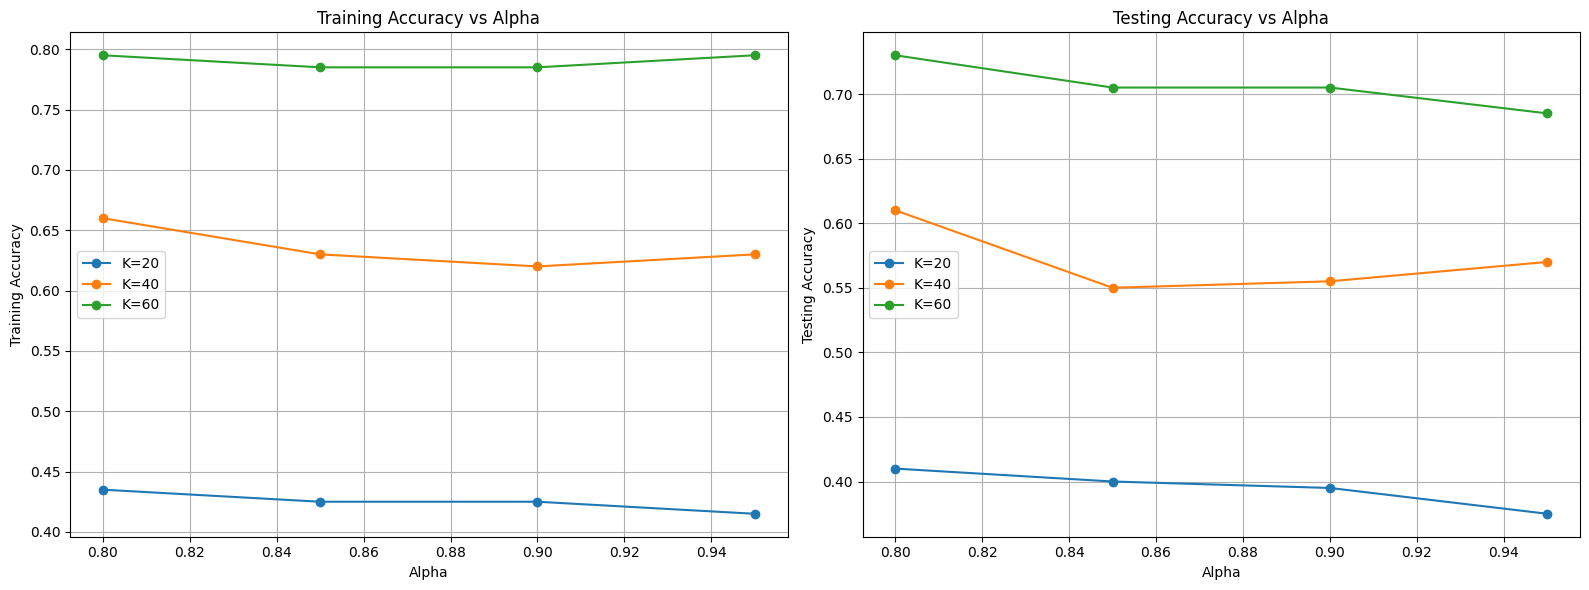

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot Training Accuracy vs Alpha
for k in k_values:
    training_accuracies = [results[alpha][k]['training_acc'] for alpha in alphas]
    axes[0].plot(alphas, training_accuracies, marker='o', label=f'K={k}')

axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Training Accuracy')
axes[0].set_title('Training Accuracy vs Alpha')
axes[0].legend()
axes[0].grid(True)

# Plot Testing Accuracy vs Alpha
for k in k_values:
    testing_accuracies = [results[alpha][k]['testing_acc'] for alpha in alphas]
    axes[1].plot(alphas, testing_accuracies, marker='o', label=f'K={k}')

axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Testing Accuracy')
axes[1].set_title('Testing Accuracy vs Alpha')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Best K-Means Model Evaluating**

In [12]:
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

Test Accuracy: 0.7750
Test F1-Score: 0.7503


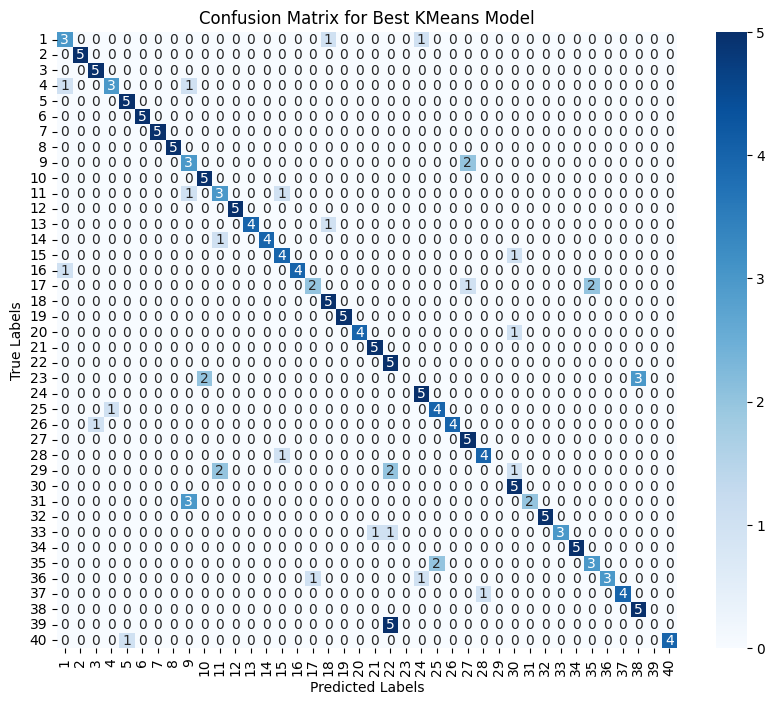

In [13]:
pca = pca_results[best_alpha]['pca']
X_test_pca = pca_results[best_alpha]['X_test_pca']

# Predict clusters for the test set
y_pred_test_cluster_indices = best_model.predict(X_test_pca)
y_pred_test = np.array([cluster_label_mapping[c] for c in cluster_indices])
# Calculate Accuracy
test_accuracy = accuracy_score(y_pred_test, y_test)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_test, average='macro')  # or 'weighted'

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print Results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(1, 41), yticklabels=np.arange(1, 41))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Best KMeans Model')
plt.show()

## GMM Algorithm

In [14]:
def map_cluster_to_id(train_clusters, y_train, K):
    cluster_to_id = {}
    for cluster in range(K):
        members = y_train[train_clusters == cluster] 
    
        if len(members) == 0:
            cluster_to_id[cluster] = -1
            print(f"Warning: cluster {cluster} has no members.")
        else:
            cluster_to_id[cluster] = np.bincount(members).argmax()
    return cluster_to_id

α=0.8, K=20 → training accuracy=0.490 testing accuracy=0.430, f1=0.316
α=0.8, K=40 → training accuracy=0.785 testing accuracy=0.685, f1=0.657
α=0.8, K=60 → training accuracy=0.930 testing accuracy=0.870, f1=0.857
α=0.85, K=20 → training accuracy=0.465 testing accuracy=0.420, f1=0.301
α=0.85, K=40 → training accuracy=0.785 testing accuracy=0.685, f1=0.646
α=0.85, K=60 → training accuracy=0.910 testing accuracy=0.820, f1=0.806
α=0.9, K=20 → training accuracy=0.445 testing accuracy=0.410, f1=0.307
α=0.9, K=40 → training accuracy=0.805 testing accuracy=0.720, f1=0.674
α=0.9, K=60 → training accuracy=0.910 testing accuracy=0.805, f1=0.789
α=0.95, K=20 → training accuracy=0.475 testing accuracy=0.410, f1=0.277
α=0.95, K=40 → training accuracy=0.785 testing accuracy=0.720, f1=0.680
α=0.95, K=60 → training accuracy=0.900 testing accuracy=0.785, f1=0.782


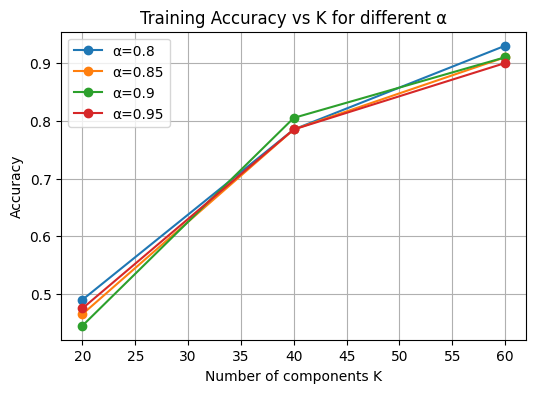

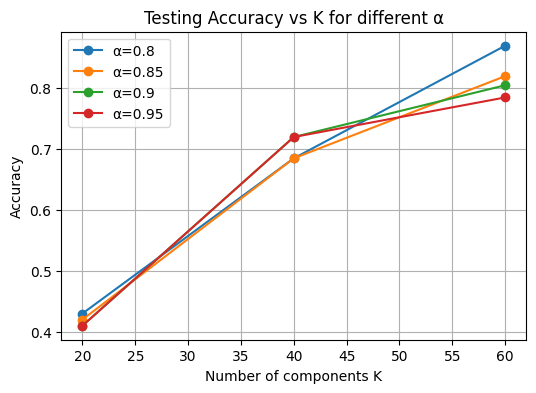

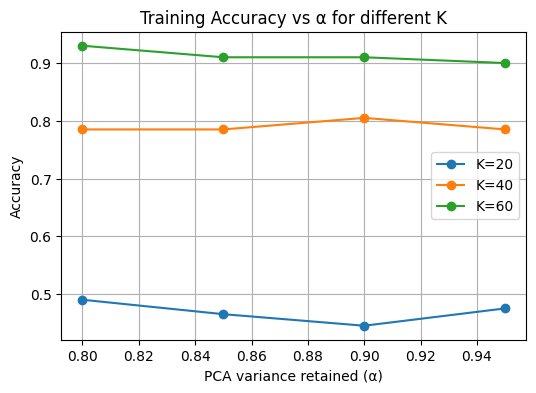

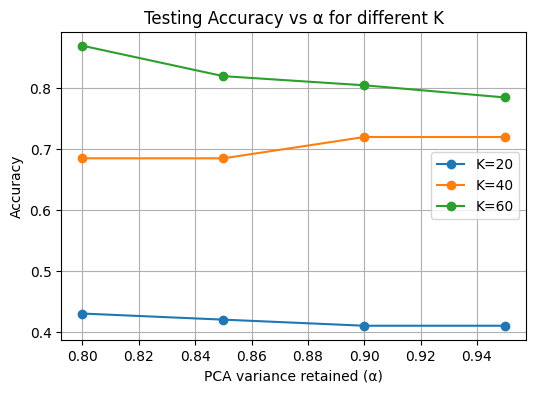


Accuracy (rows=alpha, cols=K):
K         20     40    60
alpha                    
0.80   0.490  0.785  0.93
0.85   0.465  0.785  0.91
0.90   0.445  0.805  0.91
0.95   0.475  0.785  0.90

Testing Accuracy (rows=alpha, cols=K):
K        20     40     60
alpha                    
0.80   0.43  0.685  0.870
0.85   0.42  0.685  0.820
0.90   0.41  0.720  0.805
0.95   0.41  0.720  0.785


In [15]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pandas as pd
from GMM import GMM 

alphas = [0.8, 0.85, 0.9, 0.95]
Ks = [20, 40, 60]

results = []
best_gmm = None
best_K = 0
best_alpha = 0
best_acc = 0
# Loop over each α and each K 
for alpha in alphas:
    X_train = pca_results[alpha]['X_train_pca']
    X_test = pca_results[alpha]['X_test_pca']
    
    for K in Ks:
        gmm = GMM(n_components=K, max_iter=100, tol=1e-4, random_state=42)
        gmm.fit(X_train)

        # hard‐assign each training point to a cluster
        train_clusters = gmm.perform_hard_prediction(X_train)

        # assign each cluster to the most frequent true label in that cluster 
        cluster_to_id = map_cluster_to_id(train_clusters, y_train, K)


        # training accuracy
        train_pred = np.array([cluster_to_id[c] for c in train_clusters])
        train_acc = accuracy_score(y_train, train_pred)

        # hard‐assign each test point to a cluster
        test_clusters = gmm.perform_hard_prediction(X_test)
        
        y_pred = np.array([cluster_to_id[c] for c in test_clusters])

        # testing accuracy and f1 score
        test_acc = accuracy_score(y_test, y_pred)
        f1  = f1_score(y_test, y_pred, average='macro')
        
        if train_acc > best_acc:
            best_acc = train_acc
            best_gmm = gmm
            best_K = K
            best_alpha = alpha

        # store results
        results.append({
            'alpha': alpha,
            'K': K,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc, 
            'f1_macro': f1
        })
        print(f"α={alpha}, K={K} → training accuracy={train_acc:.3f} testing accuracy={test_acc:.3f}, f1={f1:.3f}")

# to dataframe 
df = pd.DataFrame(results)
pivot_training_acc = df.pivot(index='alpha', columns='K', values='train_accuracy')
pivot_test_acc = df.pivot(index='alpha', columns='K', values='test_accuracy')


# Training Accuracy vs K (one curve per α)
plt.figure(figsize=(6,4))
for alpha in alphas:
    plt.plot(Ks, pivot_training_acc.loc[alpha], marker='o', label=f'α={alpha}')
plt.xlabel('Number of components K')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs K for different α')
plt.legend()
plt.grid(True)


# Testing Accuracy vs K (one curve per α)
plt.figure(figsize=(6,4))
for alpha in alphas:
    plt.plot(Ks, pivot_test_acc.loc[alpha], marker='o', label=f'α={alpha}')
plt.xlabel('Number of components K')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy vs K for different α')
plt.legend()
plt.grid(True)



# Training Accuracy vs α (one curve per K)
plt.figure(figsize=(6,4))
for K in Ks:
    plt.plot(alphas, pivot_training_acc[K], marker='o', label=f'K={K}')
plt.xlabel('PCA variance retained (α)')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs α for different K')
plt.legend()
plt.grid(True)


# Testing Accuracy vs α (one curve per K)
plt.figure(figsize=(6,4))
for K in Ks:
    plt.plot(alphas, pivot_test_acc[K], marker='o', label=f'K={K}')
plt.xlabel('PCA variance retained (α)')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy vs α for different K')
plt.legend()
plt.grid(True)


plt.show()

# results as table 
print("\nAccuracy (rows=alpha, cols=K):")
print(pivot_training_acc)
print("\nTesting Accuracy (rows=alpha, cols=K):")
print(pivot_test_acc)

Best model: α=0.8, K=60 → testing accuracy=0.870, f1=0.857


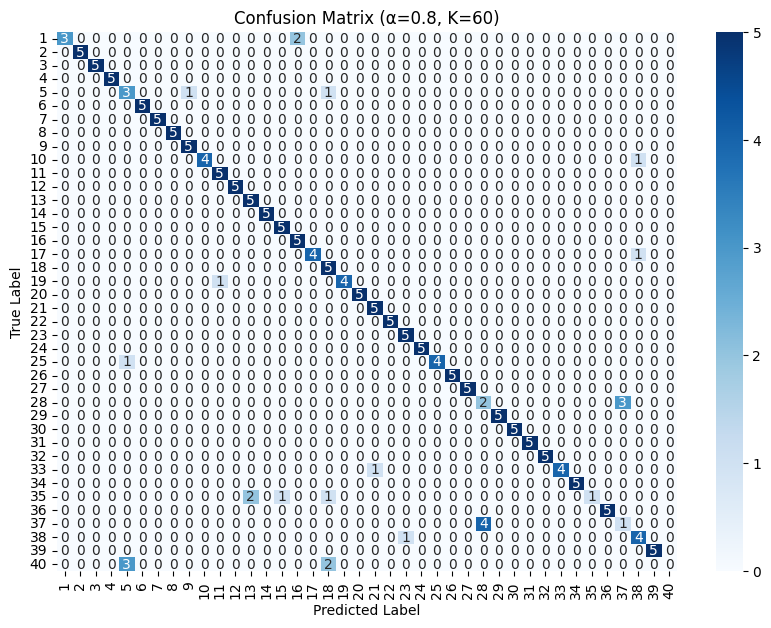

In [16]:
# Evaluate the best model on the test set
gmm_best_model = GMM(n_components=best_K, max_iter=100, tol=1e-4, random_state=42)
gmm_best_model.fit(pca_results[best_alpha]['X_train_pca'])
train_clusters = gmm_best_model.perform_hard_prediction(pca_results[best_alpha]['X_train_pca'])

# assign each cluster to the most frequent true label in that cluster
cluster_to_id = map_cluster_to_id(train_clusters, y_train, best_K)

# test clusters
test_clusters = gmm_best_model.perform_hard_prediction(pca_results[best_alpha]['X_test_pca'])
y_pred = np.array([cluster_to_id[c] for c in test_clusters])

test_acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average='macro')
print(f"Best model: α={best_alpha}, K={best_K} → testing accuracy={test_acc:.3f}, f1={f1:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 41), yticklabels=np.arange(1, 41))
plt.title(f"Confusion Matrix (α={best_alpha}, K={best_K})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## BONUS: Autoencoder
### Training

In [7]:
X_train = X[::2]
y_train = y[::2]
X_test = X[1::2]
y_test = y[1::2]

In [21]:
from autoencoder import AutoEncoder
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from math import ceil


def train_autoencoder(X_train, X_validate, input_dim, hidden_dim, bottleneck_dim, batch_size, lr, num_epochs):
    model = AutoEncoder(input_dim, hidden_dim, bottleneck_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        perm = torch.randperm(X_train.size(0))
        model.train()  
        run_loss = 0.0
        for i in range(0, X_train.size(0), batch_size):
            indices = perm[i:i + batch_size]
            batch = X_train[indices]
            data = batch[0]
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        epoch_loss = run_loss / ceil(len(X_train) / batch_size)
        if(epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
    model.eval()  
    with torch.no_grad():
        reconstructed = model(X_validate)
        loss = criterion(reconstructed, X_validate)
        avg_loss = loss.item()
    print(f'Validation Loss: {avg_loss:.4f}')
    return avg_loss
    

In [22]:
import itertools
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

validation_size = 0.2*len(X_train_tensor)
X_validate_tensor = X_train_tensor[len(X_train_tensor)-int(validation_size):]
X_train_tensor = X_train_tensor[:int(validation_size)]

best_model = None  
best_loss = float('inf')
best_config = None


# Grid search
input_dim = X_train_tensor.shape[1]
hidden_dims = [256, 512, 1024]
bottleneck_dims = [64, 128]
learning_rates = [0.001]
batch_sizes = [64, 128, 256]
epochs = 100

for hidden_dim, bottleneck_dim, lr, batch_size in itertools.product(hidden_dims, bottleneck_dims, learning_rates, batch_sizes):
    print(f"Training with hidden_dim={hidden_dim}, bottleneck_dim={bottleneck_dim}, lr={lr}, batch_size={batch_size}")
    avg_loss = train_autoencoder(
        X_train_tensor,
        X_validate_tensor,
        input_dim,
        hidden_dim,
        bottleneck_dim,
        batch_size,
        lr,
        epochs
    )
    print(f"Average loss: {avg_loss:.6f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_config = {
            'hidden_dim': hidden_dim,
            'bottleneck_dim': bottleneck_dim,
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epochs
        }
        # Save the best model
        torch.save(best_model.state_dict(), 'best_autoencoder.pth')
        print("Best model saved.")  
print("\nBest Configuration Found:")
print(best_config)
print(f"Best Loss: {best_loss:.6f}")
# Load the best model
best_model = AutoEncoder(input_dim, best_config['hidden_dim'], best_config['bottleneck_dim']) 




Training with hidden_dim=256, bottleneck_dim=64, lr=0.001, batch_size=64
Epoch [10/100], Loss: 1709.6917
Epoch [20/100], Loss: 1261.4650
Epoch [30/100], Loss: 1270.9636
Epoch [40/100], Loss: 1189.1745
Epoch [50/100], Loss: 1498.9501
Epoch [60/100], Loss: 1102.0112
Epoch [70/100], Loss: 1188.8755
Epoch [80/100], Loss: 1155.6680
Epoch [90/100], Loss: 1302.4216
Epoch [100/100], Loss: 1241.2637
Validation Loss: 13023.3613
Average loss: 13023.361328
Best model saved.
Training with hidden_dim=256, bottleneck_dim=64, lr=0.001, batch_size=128
Epoch [10/100], Loss: 1527.6752
Epoch [20/100], Loss: 1261.8015
Epoch [30/100], Loss: 1148.9401
Epoch [40/100], Loss: 1156.3237
Epoch [50/100], Loss: 1189.4288
Epoch [60/100], Loss: 1515.1994
Epoch [70/100], Loss: 1515.1581
Epoch [80/100], Loss: 1131.5773
Epoch [90/100], Loss: 1156.0571
Epoch [100/100], Loss: 1515.0648
Validation Loss: 13028.0547
Average loss: 13028.054688
Training with hidden_dim=256, bottleneck_dim=64, lr=0.001, batch_size=256
Epoch [10

### Visualization

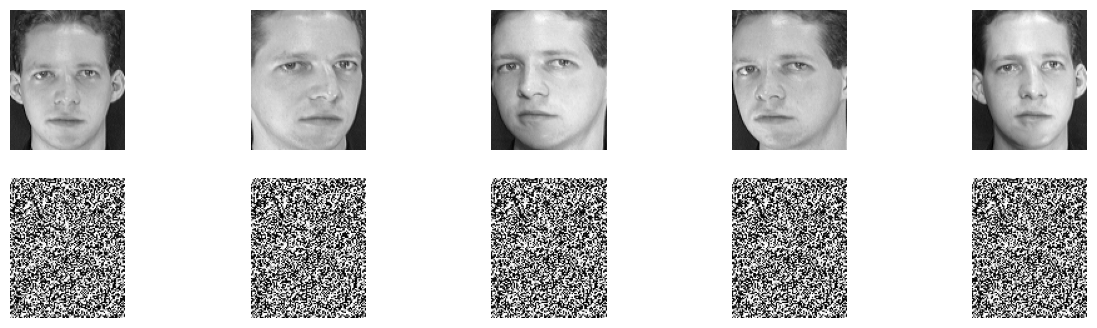

In [23]:
with torch.no_grad():
    sample = X_train_tensor[:5]
    reconstructed = best_model(sample).detach().numpy()
    fig, axs = plt.subplots(2, 5, figsize=(15, 4))
    for i in range(5):
        axs[0, i].imshow(sample[i].reshape(112, 92), cmap='gray')        # original
        axs[0, i].axis('off')
        axs[1, i].imshow(reconstructed[i].reshape(112, 92), cmap='gray') # reconstructed
        axs[1, i].axis('off')

    plt.show()


In [24]:
from math import ceil

# Data prep for kmeans and GMM using best model
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Data prep for kmeans and GMM using best model
hidden_dim = 1024
bottleneck_dim = 128
lr = 0.001
batch_size = 128 # sometimes 128
num_epochs = 50 # the more the better


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
input_dim = X_train_tensor.shape[1]

best_model = AutoEncoder(input_dim, hidden_dim, bottleneck_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=lr)

for epoch in range(num_epochs):
    perm = torch.randperm(X_train_tensor.size(0))
    best_model.train()  
    run_loss = 0.0
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = perm[i:i + batch_size]
        batch = X_train_tensor[indices]
        data = batch[0]
        optimizer.zero_grad()
        outputs = best_model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    epoch_loss = run_loss / ceil(len(X_train_tensor) / batch_size)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

X_train_autoencoder = best_model.encode(X_train_tensor).detach().numpy()
X_test_autoencoder = best_model.encode(X_test_tensor).detach().numpy()
np.save('./npy/X_train_autoencoder.npy', X_train_autoencoder)
np.save('./npy/X_test_autoencoder.npy', X_test_autoencoder)

### KMeans + Autoencoder

K: 20, Training Accuracy: 0.4200, Testing Accuracy: 0.36
K: 40, Training Accuracy: 0.5800, Testing Accuracy: 0.495
K: 60, Training Accuracy: 0.7250, Testing Accuracy: 0.63


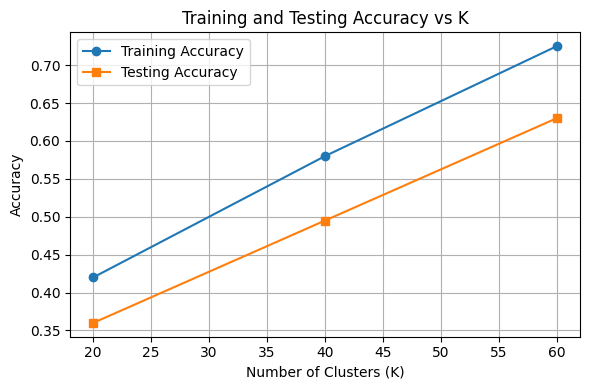

In [25]:
k_values = [20, 40, 60]
results = {}  # To store accuracy for each (K)

best_acc = 0
best_model = None
cluster_label_mapping = []

for k in k_values:
    kmeans_model = Models.KMeans(n_clusters = k, random_state = 42)

    # Fit KMeans
    kmeans_model.fit(X_train_autoencoder)

    # Predict clusters
    cluster_indices = kmeans_model.predict(X_train_autoencoder)
    cluster_label_map = mapping_clusters_to_labels(cluster_indices, y_train)
    
    y_pred_train = np.array([cluster_label_map[c] for c in cluster_indices])
    
    y_pred_test_cluster_indices = kmeans_model.predict(X_test_autoencoder)
    
    training_acc = accuracy_score(y_pred_train, y_train)

    test_cluster_indices = kmeans_model.predict(X_test_autoencoder)
    
    y_pred_test = np.array([cluster_label_map[c] for c in test_cluster_indices])
    
    training_acc = accuracy_score(y_pred_train, y_train)
    testing_acc = accuracy_score(y_pred_test, y_test)
    
    if training_acc > best_acc:
        best_acc = training_acc
        best_model = kmeans_model
        cluster_label_mapping = cluster_label_map

    results[k] = {
        "training_acc": training_acc,
        "testing_acc": testing_acc
    }
    print(f'K: {k}, Training Accuracy: {training_acc:.4f}, Testing Accuracy: {testing_acc}')


# Extract training and testing accuracy for each K
ks = list(results.keys())
train_accuracies = [results[k]['training_acc'] for k in ks]
test_accuracies = [results[k]['testing_acc'] for k in ks]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(ks, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(ks, test_accuracies, marker='s', label='Testing Accuracy')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs K')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Best K-Means Model Evaluating**

Test Accuracy: 0.7250
Test F1-Score: 0.6983


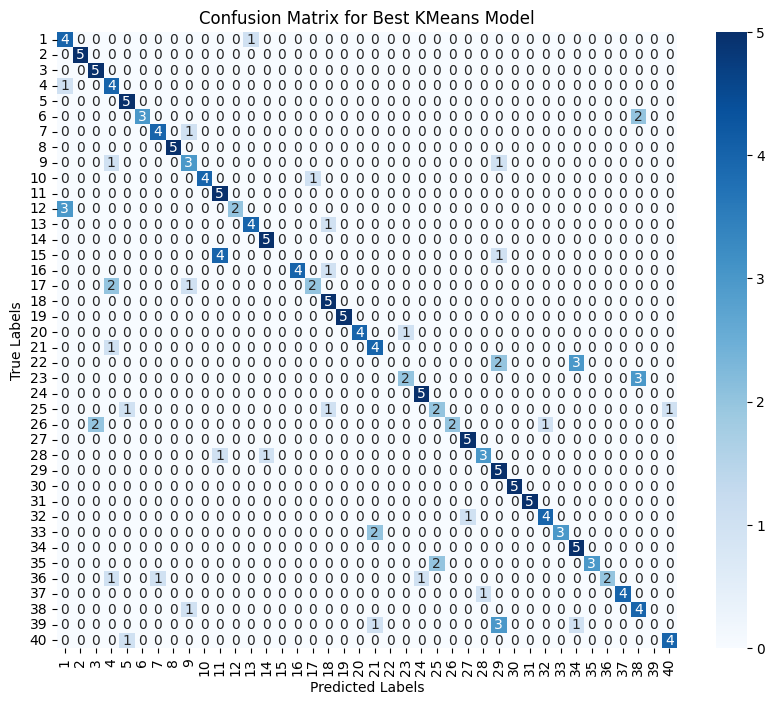

In [26]:

# Predict clusters for the test set
y_pred_test_cluster_indices = best_model.predict(X_test_autoencoder)
y_pred_test = np.array([cluster_label_mapping[c] for c in cluster_indices])
# Calculate Accuracy
test_accuracy = accuracy_score(y_pred_test, y_test)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_test, average='macro')  # or 'weighted'

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print Results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(1, 41), yticklabels=np.arange(1, 41))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Best KMeans Model')
plt.show()

## GMM Algorithm

K=20 → training accuracy=0.440 testing accuracy=0.325, f1=0.235
K=40 → training accuracy=0.630 testing accuracy=0.470, f1=0.430
K=60 → training accuracy=0.835 testing accuracy=0.700, f1=0.692


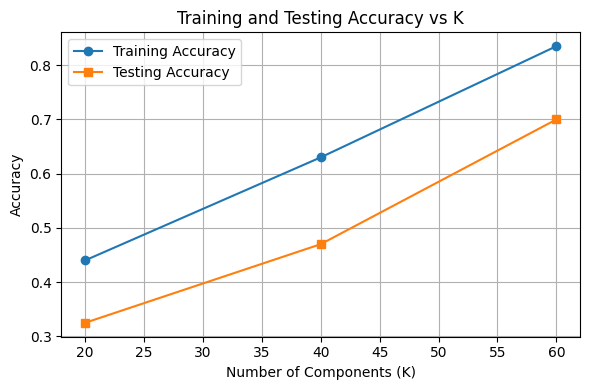

In [27]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pandas as pd
from GMM import GMM 

Ks = [20, 40, 60]

results = []
best_gmm = None
best_K = 0
best_acc = 0
# Loop over and each K 
for K in Ks:
    gmm = GMM(n_components=K, max_iter=100, tol=1e-4, random_state=42)
    gmm.fit(X_train_autoencoder)

    # hard‐assign each training point to a cluster
    train_clusters = gmm.perform_hard_prediction(X_train_autoencoder)

    # assign each cluster to the most frequent true label in that cluster 
    cluster_to_id = map_cluster_to_id(train_clusters, y_train, K)


    # training accuracy
    train_pred = np.array([cluster_to_id[c] for c in train_clusters])
    train_acc = accuracy_score(y_train, train_pred)

    # hard‐assign each test point to a cluster
    test_clusters = gmm.perform_hard_prediction(X_test_autoencoder)
    
    y_pred = np.array([cluster_to_id[c] for c in test_clusters])

    # testing accuracy and f1 score
    test_acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='macro')
    
    if train_acc > best_acc:
        best_acc = train_acc
        best_gmm = gmm
        best_K = K

    # store results
    results.append({
        'K': K,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc, 
        'f1_macro': f1
    })
    print(f"K={K} → training accuracy={train_acc:.3f} testing accuracy={test_acc:.3f}, f1={f1:.3f}")

# to dataframe 
df = pd.DataFrame(results)
pivot_training_acc = df.pivot( columns='K', values='train_accuracy')
pivot_test_acc = df.pivot(columns='K', values='test_accuracy')

# Extract data
Ks = df['K']
train_accs = df['train_accuracy']
test_accs = df['test_accuracy']

# Plot
plt.figure(figsize=(6, 4))
plt.plot(Ks, train_accs, marker='o', label='Training Accuracy')
plt.plot(Ks, test_accs, marker='s', label='Testing Accuracy')
plt.xlabel('Number of Components (K)')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs K')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Best model: K=60 → testing accuracy=0.700, f1=0.692


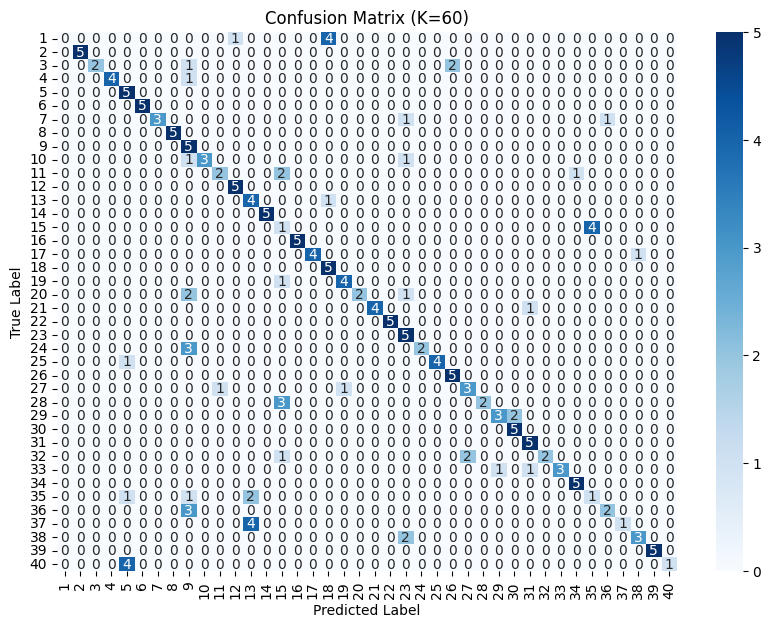

In [28]:
# Evaluate the best model on the test set
gmm_best_model = GMM(n_components=best_K, max_iter=100, tol=1e-4, random_state=42)
gmm_best_model.fit(X_train_autoencoder)
train_clusters = gmm_best_model.perform_hard_prediction(X_train_autoencoder)

# assign each cluster to the most frequent true label in that cluster
cluster_to_id = map_cluster_to_id(train_clusters, y_train, best_K)

# test clusters
test_clusters = gmm_best_model.perform_hard_prediction(X_test_autoencoder)
y_pred = np.array([cluster_to_id[c] for c in test_clusters])

test_acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average='macro')
print(f"Best model: K={best_K} → testing accuracy={test_acc:.3f}, f1={f1:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 41), yticklabels=np.arange(1, 41))
plt.title(f"Confusion Matrix (K={best_K})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()